# Probabilistic K-Nearest Neighbors with an OU-process

$$
    dS_{t+1} = \kappa(\bar S - S_t) + \sigma dW_t
$$

Where

* $\kappa$ is the force of the mean-reverting effect
* $\bar S$ is the mean-reverting value
* $\sigma$ is the stardard deviation of the process

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import randn, randint, rand
from tqdm.notebook import tqdm

In [202]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)

In this example, we will train a pknn using an OU-process.

In [3]:
def simulate_ou_process(x0, xbar, kappa, sigma, T, dt):
    time = np.arange(0, T, dt)
    nsteps = len(time)
    x = np.zeros(nsteps)
    x[0] = x0
    errs = np.random.randn(nsteps - 1)
    
    cnst0 =  (1 - kappa * dt)
    cnst1 = dt * kappa * xbar
    cnst2 = np.sqrt(dt) * sigma
    for t in range(nsteps - 1):
        x[t + 1] = x[t] + dt * (kappa * (xbar - x[t])) + np.sqrt(dt) * sigma * errs[t]
        x[t + 1] = x[t] * cnst0 + cnst1 + cnst2 * errs[t]
        

    return time, x


def ts_supervised(data, n_in=1, n_out=1):
    """
    Transform a matrix of size TxS to a supervised machine learning
    problem.
    
    n_in: int
        The number of previous steps to consider. This is the
        X matrix of values (x_{t-n_in}, ..., x_{t-1}) as input 
        to the model
        
    n_out: int
        The number of posterior steps to consider. This is a 
        Y matrix of values (y_{t}, y_{t+1}, ..., y_{t+n_out})
        which serves as output to the model
    """
    _, n_vars = data.shape
    base_cols = data.columns
    cols, col_names = [], []
    agg = {}
    # Input sequence (t-n, .., t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        col_names.extend([f"{base_cols[j-1]}(t-{i})"
                          for j in range(1, n_vars + 1)])
    # forecast sequence (t, .., t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        col_names.extend([f"{base_cols[j-1]}(t+{i})".replace("+0", "")
                           for j in range(1, n_vars + 1)])

    agg = pd.concat(cols, axis=1).dropna()
    agg.columns = col_names
    return agg


def compute_distance(x, X):
    D = ((x[..., None] - X.T[:, None, :]) ** 2).sum(axis=0)
    return D

def find_k_closest(X, k=6):
    D = compute_distance(X.T, X)
    nearest = np.argsort(D)[..., 1 :k + 1]
    return nearest


def compute_likelihood(X, y, beta, k):
    Q = len(np.unique(y))
    # Comparing the "k" closest datapoints of xi to yi
    num = y[find_k_closest(X, k=k)] == y[:, None]
    num = np.exp(beta * num.mean(axis=1))
    
    den = y[find_k_closest(X, k=k), None] == np.arange(Q)[None, None, :]
    den = np.exp(beta * den.mean(axis=1)).sum(axis=-1)
    
    likelihood = num / den
    return likelihood.prod()


def knn_mcmc(X, y, k, beta, target_samples=10_000, eta=1):
    samples = []
    n_rounds = 0
    pbar = tqdm(total=target_samples)
    while len(samples) < target_samples:
        n_rounds += 1
        beta_hat = np.abs(beta + randn() * eta)

        k_hat = np.abs(k + randint(-4, 4))
        k_hat = max(1, k_hat)

        L_hat = compute_likelihood(X, y, beta_hat, k_hat)
        L = compute_likelihood(X, y, beta, k)
        A = min(1, L_hat / L)
        if A > rand():
            samples.append([k_hat, beta_hat])
            k, beta = k_hat, beta_hat
            pbar.update(1)
    return np.array(samples), target_samples / n_rounds

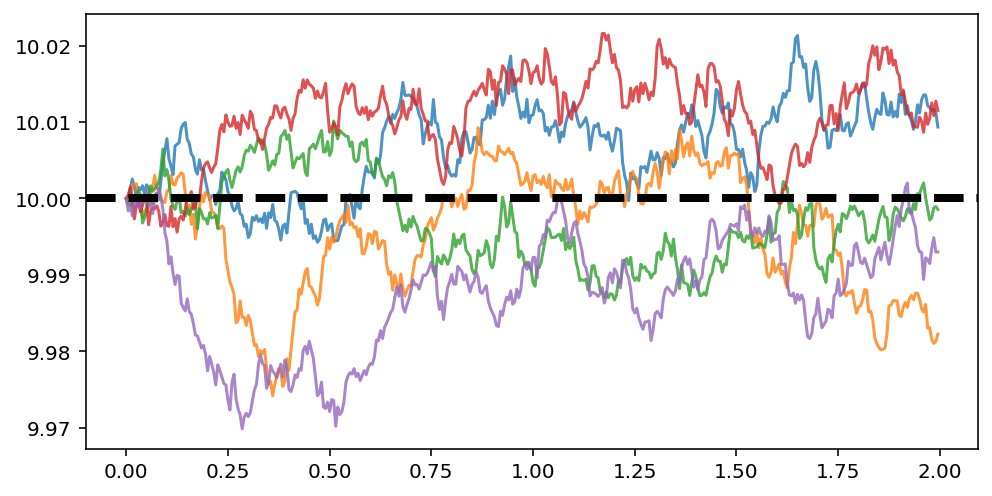

In [4]:
np.random.seed(314)
xbar = 10

for _ in range(5):
    plt.plot(*simulate_ou_process(10, xbar, 1, 0.02, T=2, dt=0.005),
             alpha=0.8)
plt.axhline(y=xbar, linewidth=4, c="black", linestyle="--");

In [484]:
np.random.seed(314)
x0, xbar = 10, 10
T = 30
t, St = simulate_ou_process(x0, xbar, 1, 0.2, T=T, dt=0.05)
St = pd.DataFrame({"S": St}, index=t)

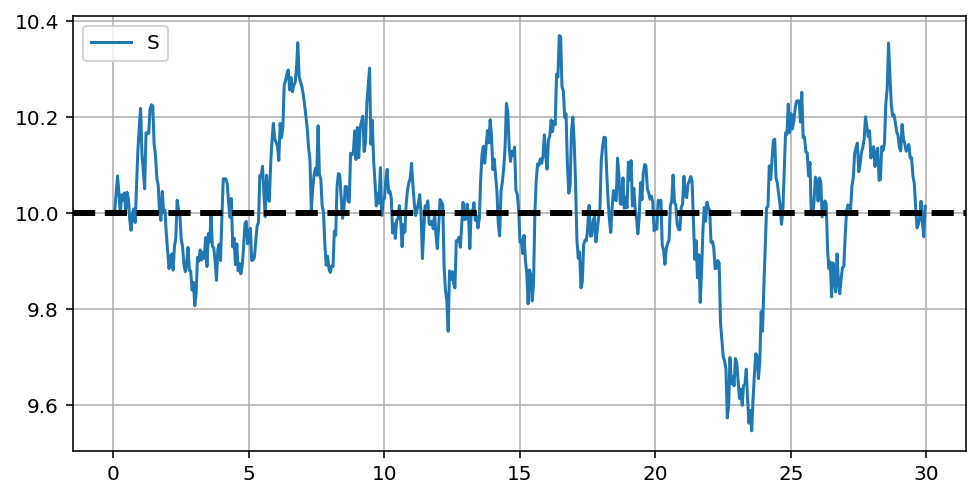

In [485]:
St.plot()
plt.grid()
plt.axhline(y=xbar, linewidth=3, c="black", linestyle="--", zorder=2)

In [7]:
X = ts_supervised(St, n_in=10, n_out=10)
X.shape

(581, 20)

In this first exercise, we will focus in capturing mean-reverting tredns that are below $\bar S$. We are interested in knowning whether

In [8]:
X_below = X[X["S(t)"] < xbar]

y_below = (X_below.iloc[:, -4:] > xbar).any(axis=1) * 1.
X_below = X_below.loc[:, :"S(t)"].values

In [9]:
X_below.shape[0] / X.shape[0]

0.4044750430292599

In [10]:
target_samples = 5_000

In [11]:
samp2, prop_accept2 = knn_mcmc(X_below, y_below.values, k=1, beta=1, target_samples=target_samples)

In [12]:
samp1, prop_accept1 = knn_mcmc(X_below, y_below.values, k=0, beta=0, target_samples=target_samples)

In [14]:
N_range = np.arange(1, target_samples + 1)[:, None]
mu_1 = samp1.cumsum(axis=0) / N_range
mu_2 = samp2.cumsum(axis=0) / N_range

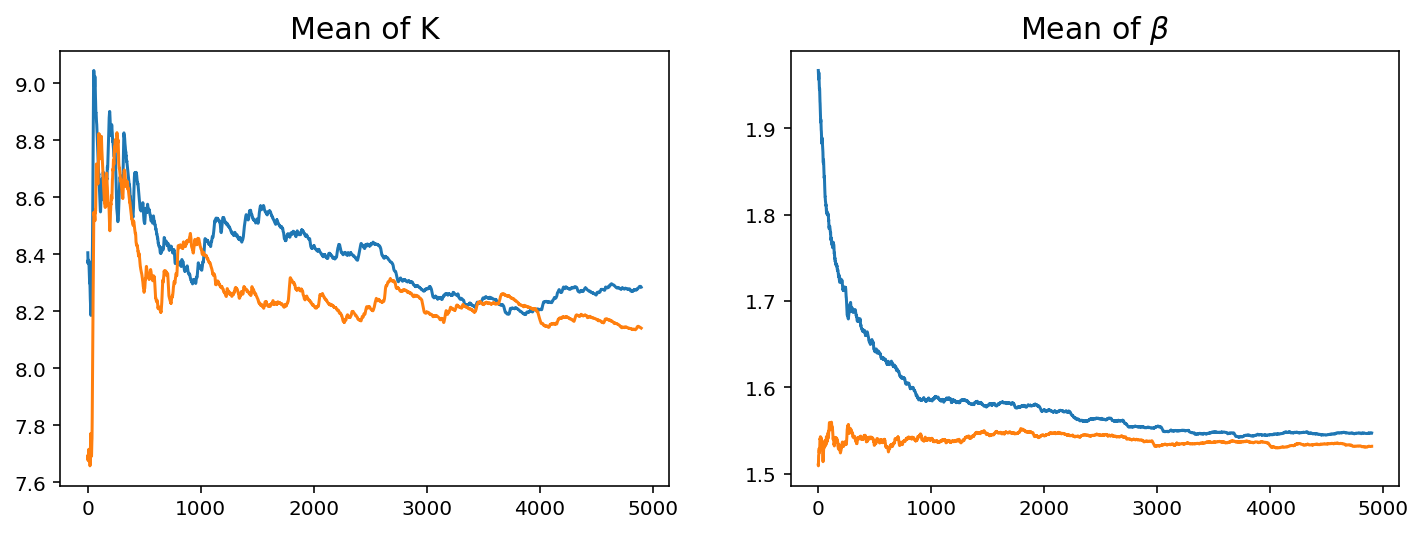

In [15]:
labels = ["K", r"$\beta$"]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, (axi, label) in enumerate(zip(ax, labels)):
    axi.plot(mu_1[100:, i])
    axi.plot(mu_2[100:, i])
    axi.set_title(f"Mean of {label}", fontsize=15)

In [296]:
samp2

array([[4.        , 1.13969675],
       [2.        , 0.5571455 ],
       [2.        , 0.51324324],
       ...,
       [7.        , 2.04755758],
       [5.        , 1.4984364 ],
       [8.        , 1.41840481]])

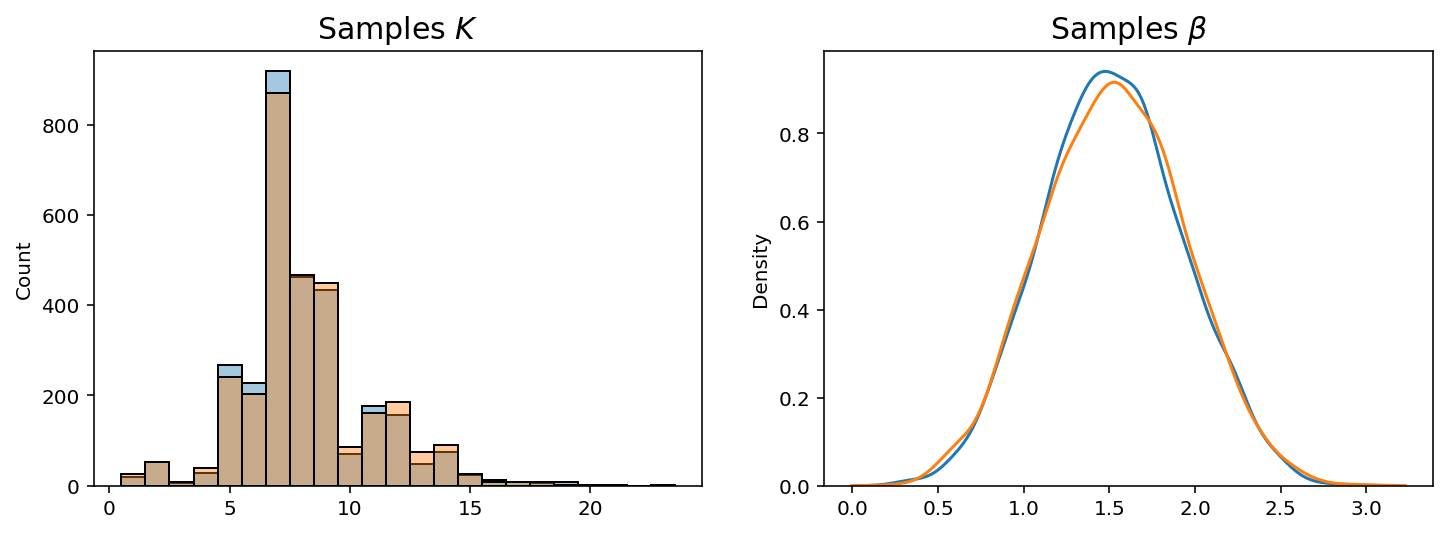

In [264]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
burnout = 2000
sns.histplot(samp2[burnout:, 0], ax=ax[0], alpha=0.4, discrete=True)
sns.histplot(samp1[burnout:, 0], ax=ax[0], alpha=0.4, color="tab:orange", discrete=True)

sns.kdeplot(samp2[burnout:, 1], ax=ax[1], alpha=0.2, color="tab:blue")
sns.kdeplot(samp1[burnout:, 1], ax=ax[1], alpha=0.2, color="tab:orange")
ax[0].set_title("Samples $K$", fontsize=15)
ax[1].set_title(r"Samples $\beta$", fontsize=15);

## Testing the model

In [508]:
np.random.seed(31415)
T = 20
t, St_test = simulate_ou_process(St.iloc[-1].item(), xbar, 1, 0.2, T=T, dt=0.05)
St_test = pd.DataFrame({"S": St_test}, index=t)

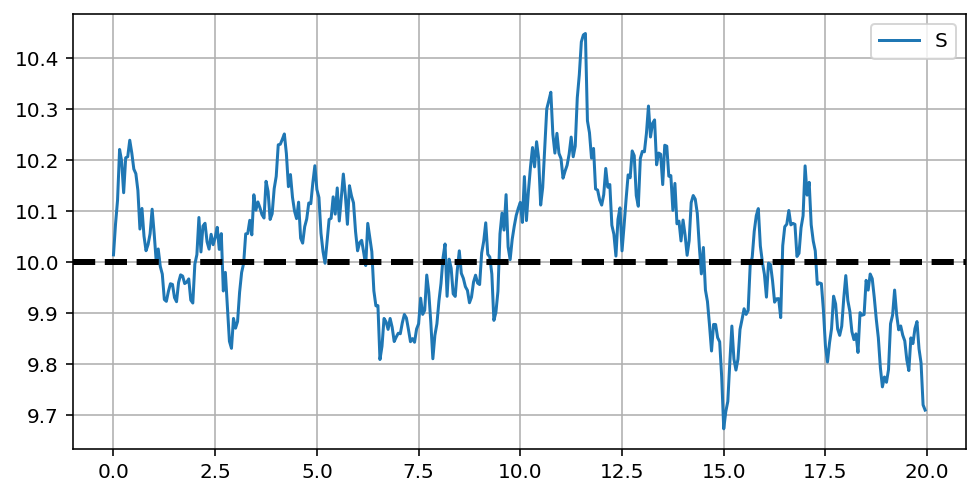

In [509]:
St_test.plot()
plt.grid()
plt.axhline(y=xbar, linewidth=3, c="black", linestyle="--", zorder=2)

In [510]:
X_test = ts_supervised(St_test, n_in=10, n_out=10)

X_test_below = X_test[X_test["S(t)"] < xbar]

In [511]:
y_test_below = (X_test_below.iloc[:, -4:] > xbar).any(axis=1) * 1.
X_test_below = X_test_below.loc[:, :"S(t)"].values

In [512]:
D = np.sum((X_test_below[:, None, :] - X_below[None, ...]) ** 2, axis=-1)
D.shape

(162, 235)

In [513]:
samples_mcmc = np.concatenate([samp1[burnout:], samp2[burnout:]])
D_argsort = D.argsort()

In [514]:
n_samples, _ = samples_mcmc.shape
Q = 2
n_test, *_ = y_test_below.shape
classes = np.arange(Q)
P_grid = np.zeros((n_test, n_samples))
for i, (k_star, beta_star) in enumerate(samples_mcmc):
    k_star = int(k_star)
    nearest = D_argsort[..., :k_star]
    y_nearest = y_below.values[nearest]
    num = y_nearest == 1
    num = np.exp(beta_star * num.mean(axis=-1))
    
    den = y_nearest[..., None] == classes[None, None, :]
    den = np.exp(beta_star * den.mean(axis=1)).sum(axis=-1)
    
    P_grid[:, i] = num / den

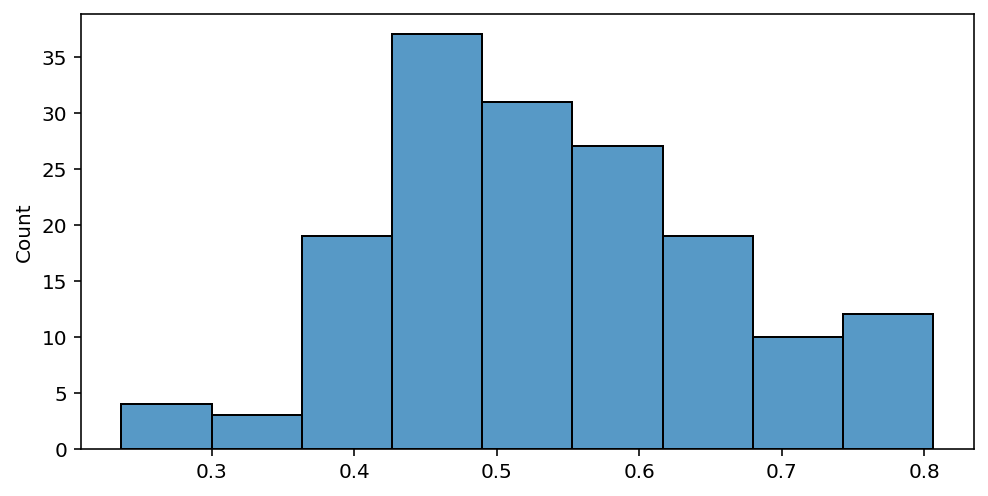

In [515]:
y_test_proba = P_grid.mean(axis=1)
sns.histplot(y_test_proba);

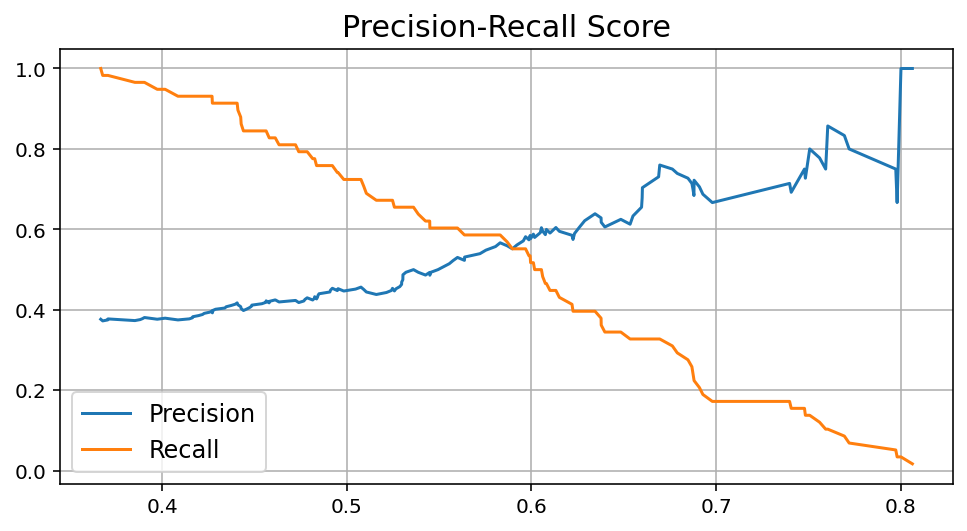

In [516]:
prec, rec, threshold = precision_recall_curve(y_test_below, y_test_proba)
plt.plot(threshold, prec[:-1], label="Precision")
plt.plot(threshold, rec[:-1], label="Recall")
plt.legend(fontsize=12)
plt.title("Precision-Recall Score", fontsize=15)
plt.grid()

In [517]:
y_test_pred = y_test_proba > 0.6

In [518]:
confusion_matrix(y_test_below, y_test_pred)

array([[83, 21],
       [28, 30]])

In [519]:
# tp / (tp + fp)
precision_score(y_test_below, y_test_pred)

0.5882352941176471

In [520]:
# tp / (tp + fn)
recall_score(y_test_below, y_test_pred)

0.5172413793103449

In [521]:
y_test_range = y_test_proba[:, None] + np.array([[-1, 1]]) * P_grid.std(axis=1, keepdims=True)
y_test_pred = (y_test_range > 0.6).all(axis=1) * 1

In [522]:
confusion_matrix(y_test_below, y_test_pred)

array([[96,  8],
       [38, 20]])

In [523]:
# tp / (tp + fp)
precision_score(y_test_below, y_test_pred)

0.7142857142857143

In [524]:
# tp / (tp + fn)
recall_score(y_test_below, y_test_pred)

0.3448275862068966

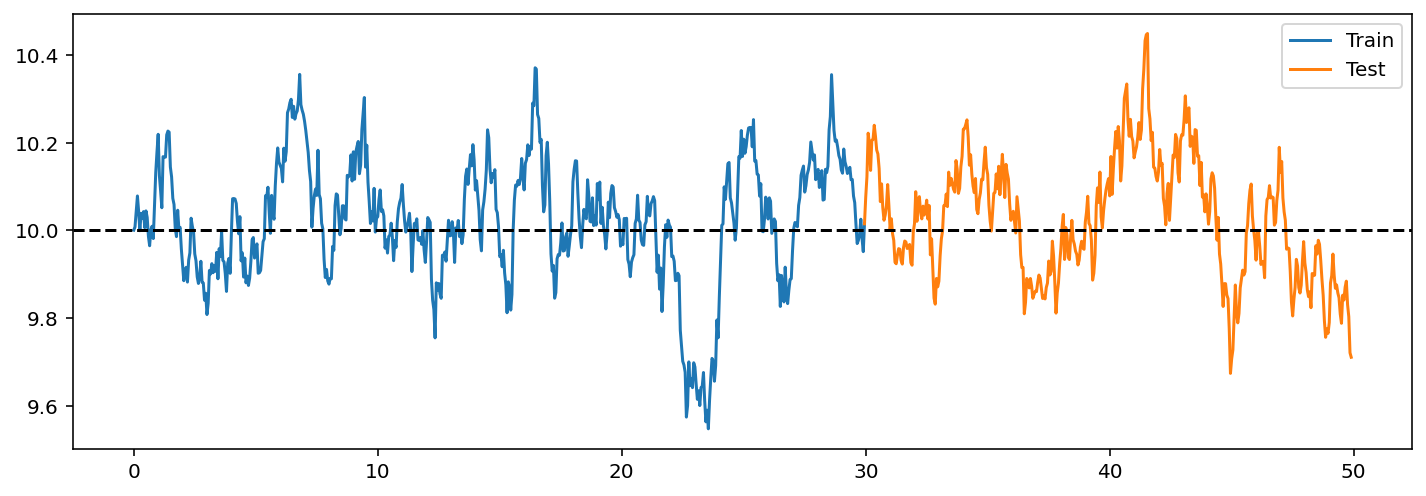

In [525]:
fig, ax = plt.subplots(figsize=(12, 4))
St.rename({"S": "Train"}, axis=1).plot(ax=ax)
St_test.rename({"S": "Test"}, axis=1).set_index(St_test.index + St.index.max()).plot(ax=ax)
plt.axhline(y=xbar, c="black", linestyle="--")